<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries-and-functions" data-toc-modified-id="Libraries-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries and functions</a></span><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Definition-of--functions-used-locally" data-toc-modified-id="Definition-of--functions-used-locally-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Definition of  functions used locally</a></span></li></ul></li><li><span><a href="#Options" data-toc-modified-id="Options-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Options</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Create-base-indices" data-toc-modified-id="Create-base-indices-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create base indices</a></span><ul class="toc-item"><li><span><a href="#Market-cap-weighted" data-toc-modified-id="Market-cap-weighted-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Market cap weighted</a></span></li><li><span><a href="#Equal-weights" data-toc-modified-id="Equal-weights-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Equal weights</a></span></li><li><span><a href="#compute-index-returns" data-toc-modified-id="compute-index-returns-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>compute index returns</a></span></li></ul></li><li><span><a href="#Index-based-on-model-predictions" data-toc-modified-id="Index-based-on-model-predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Index based on model predictions</a></span><ul class="toc-item"><li><span><a href="#Weight-generation" data-toc-modified-id="Weight-generation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Weight generation</a></span></li><li><span><a href="#Build-your-strategy" data-toc-modified-id="Build-your-strategy-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Build your strategy</a></span></li><li><span><a href="#Build-index" data-toc-modified-id="Build-index-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Build index</a></span><ul class="toc-item"><li><span><a href="#Monthly-index-levels" data-toc-modified-id="Monthly-index-levels-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Monthly index levels</a></span></li></ul></li></ul></li></ul></div>

# Libraries and functions

## Import libraries

Need to be able to access functions in base_dir/src

In [1]:
# libraries

# general
import sys
import os

import itertools

import dateutil.relativedelta as relativedelta

import datetime
import numpy as np
import pandas as pd

# plotting
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# # statistics and machine learning

from IPython.display import display
pd.options.display.max_columns = None

# # add the base path to python system path
path = os.getcwd()
#dir_up = os.path.abspath(os.path.join(path, os.pardir))
base_path = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(base_path)


# from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from matplotlib import gridspec


# # libraries within package
from src.finance_functions import multiple_returns_from_levels_vec, project_to_first
from src.finance_functions import df_restrict_dates
from src.automotive_dictionaries import equity_name2first_date

from src.index_functionality import index_levels_from_returns

from src.financial_metrics import extract_performance

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

# Options

# Load data

In [3]:
filename = '../data/data_sample_monthly.csv'
infile = filename
df_comb_long = pd.read_csv(infile)
df_comb_long['date'] = pd.to_datetime(df_comb_long['date'])

In [4]:
#df_comb_long.head()

In [5]:
#eq_name = 'Equity Parent'
eq_name = 'company'
df_prices = df_comb_long.pivot(values='stock_price', index='date', columns=eq_name)


# monthly returns
df_returns = multiple_returns_from_levels_vec(df_prices.ffill())

# Create base indices 

In [6]:
df_market_cap = df_comb_long.pivot(values='MarketCap_Mlns', index='date', columns=eq_name)
df_market_cap.index = df_market_cap.index.map(project_to_first)

# deal with the missing values by taking the previously available one
df_market_cap.ffill(inplace=True)

# set to zero when not available, this takes care of the market cap weights

for col in df_market_cap.columns:
    first_date = project_to_first(equity_name2first_date[col])
    mask = df_market_cap.index < first_date
    df_market_cap.loc[mask, col] = 0.0
    #print(first_date)

In [7]:
#df_market_cap.head()

## Market cap weighted

In [8]:
total_market_cap = df_market_cap.sum(axis=1)
# weights determined in the same month as market cap
df_weights = df_market_cap.div(total_market_cap, axis=0)

In [9]:
# the weights for the index should be determined by past information, 
# i.e.by previous month market_cap
#df_weights_mc = df_weights.shift(1).bfill()
df_weights_mc = df_weights.shift(1)

## Equal weights

In [10]:
df_temp = (df_weights_mc > 0.0).astype(int)
df_weights_equal = df_temp.div(df_temp.sum(axis=1), axis=0)


## compute index returns

In [11]:
df_mc_index_returns = pd.DataFrame((df_returns * df_weights_mc).sum(axis=1),columns=['mc_return'])
df_mc_index_returns.dropna(inplace=True)

df_equal_index_returns = pd.DataFrame((df_returns * df_weights_equal).sum(axis=1),columns=['equal_return'])
df_equal_index_returns.dropna(inplace=True)

# Index based on model predictions


Base indices
 * market cap weighted
 * equal weighted 


## Weight generation

In [12]:
l_base_weights = ['Market Cap', 'Equal']

l_weighting_schemes = ['0']

# Cartesian product tuples
l_weights = list(itertools.product(*[l_base_weights,l_weighting_schemes]))

In [13]:
# WEIGHT ADJUSTMENTS OPTIONS

d_weights = {}


In [14]:
#execution loop

for base_mod, scheme in l_weights:
    print(base_mod, scheme)
    if base_mod == 'Market Cap' :
        df_base_weights =  df_weights_mc.copy()
    if base_mod == 'Equal' :
        df_base_weights =  df_weights_equal.copy()
        
    
    df_mod_weights = df_base_weights.copy()
    
    name_d  = base_mod + ' ' + scheme
    d_weights[name_d] = df_mod_weights


Market Cap 0
Equal 0


## Build your strategy

In [15]:
# do something better than random

df_rand = pd.DataFrame(np.random.uniform(low=0.0, high=0.01, size=(len(df_weights_mc.index), len(df_weights_mc.columns))), 
                       columns=list(df_weights_mc.columns), index=df_weights_mc.index)
df_w = df_weights_mc + df_rand
df_w = df_w.div(df_w.sum(axis=1), axis=0)

In [16]:
d_weights['Market Cap smart modify'] = df_w


In [ ]:
# # SCHEMATIC: CODE DOES NOT EXECUTE LIKE THIS
# # possible loop for training a model
# # and producing df_oos_predictions

# # alternatively use portfolio optimization


# x_names = ['feature1',...]
# y_name = 'returns'

# prediction_dates = df_weights_mc.index[24:]

# for date in prediction_dates:
#     #print(date)
    
#     train_ini_date = date + relativedelta.relativedelta(months=-24)
#     train_final_date = date + relativedelta.relativedelta(months=-1)
    
#     df1 = df_restrict_dates(df_comb_long, train_ini_date, train_final_date)
        
#     df_x_train = df1[x_names].copy()
#     df_y_train = df1[[y_name]].copy()

#     X_train_full = df_x_train.values
#     y_train_full = df_y_train[y_name].values
    
#     model.fit(X_train_full, y_train_full, sample_weight=sample_weights) 
    
            
#     ##### oos results
#     df2 = df_restrict_dates(df_comb_long, date, date)
#     df_x = df2[x_names].copy()    
#     X_oos = df_x.values
    
#     predictions = model.predict(X_oos)
#     df_oos_predictions.loc[date] = predictions

In [ ]:
# # SCHEMATIC: CODE DOES NOT EXECUTE LIKE THIS
# # possible loop for weight updates (schematic)
# # based on model predictions df_oos_predictions

# df_base_weights =  df_weights_mc.copy()    
# df_mod_weights = df_base_weights.copy()

    
# for date in prediction_dates:

#     # assume you have made some predictions
#     predictions = df_oos_predictions.loc[date].values 

#     # relate predictions to weight updates
            
#     weights_mod = ....

#     # possibly apply capping rules
    
#     df_mod_weights.loc[date] = weights_mod 

# name_d  = 'xx'
# d_weights[name_d] = df_mod_weights


## Build index

### Monthly index levels

In [17]:
# build date frame with indices (no rebalancing)

start_date = datetime.datetime(2009,1,1)
end_date = datetime.datetime(2015,12,31)

starting_level = 100

df_r_in = df_restrict_dates(df_returns, start_date, end_date)
frequency = 'monthly'

for k, name in enumerate(sorted(d_weights.keys())):
    print(name)
    
    df_w_in = df_restrict_dates(d_weights[name], start_date, end_date)
    df_temp  =  index_levels_from_returns(df_w_in, df_r_in, out_field=name, starting_level=starting_level, 
                                          transaction_costs=False, frequency=frequency)
    if k == 0:
        df_i_comb = df_temp
    else:
        df_i_comb = df_i_comb.merge(df_temp, left_index=True, right_index=True)              

Equal 0
Market Cap 0
Market Cap smart modify


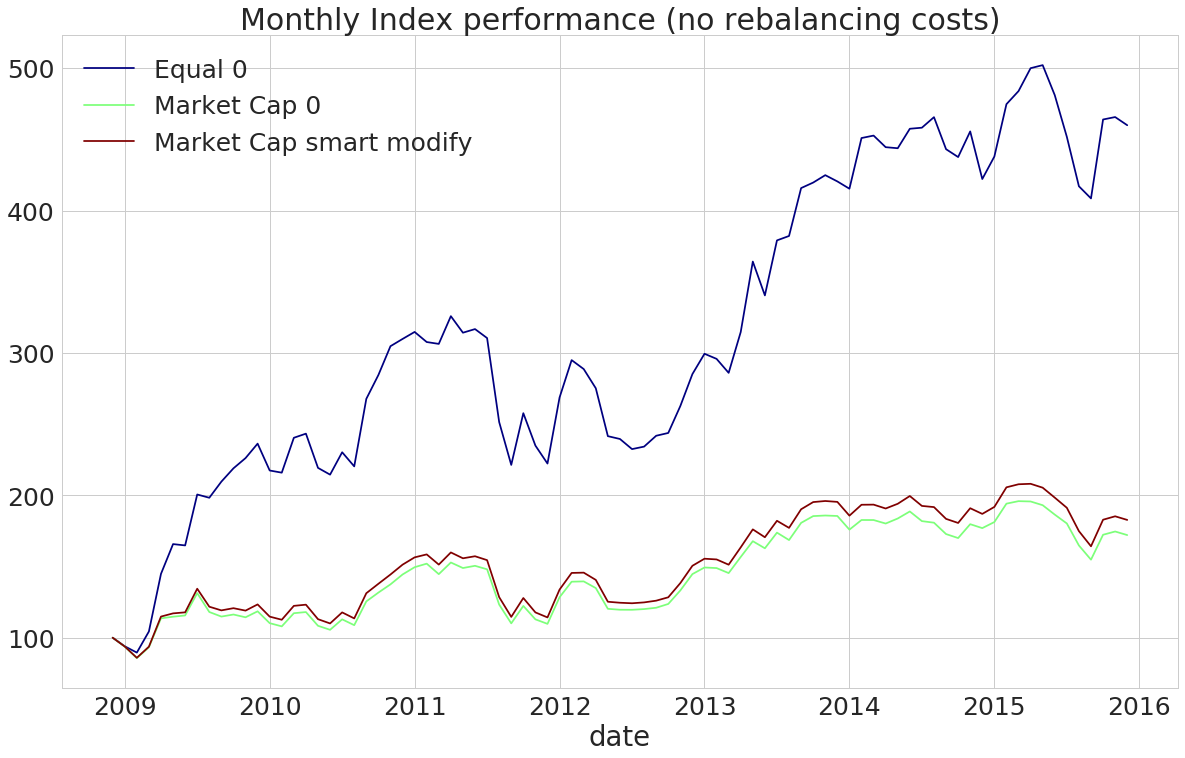

In [18]:
# plot without rebalancing costs   
font = {'size'   : 24}

mpl.rc('font', **font)
cm = plt.get_cmap('jet')
#cm = plt.get_cmap('viridis')

sns.set(font_scale=2.5)
sns.set_style("whitegrid")

#fields = 'Equal'
#fields = 'Market Cap'
fields = None

headers = df_i_comb.columns

if fields is not None:
    headers = list(filter(lambda s: fields in s, df_i_comb.columns))
    
df_i_comb[headers].plot(figsize=(20,12), colormap=cm)
plt.title(frequency.title() + ' Index performance (no rebalancing costs)')
print()

In [19]:
extract_performance(df_i_comb[headers])

,Equal 0,Market Cap 0,Market Cap smart modify
Total Return,3.599287,0.720796,0.827223
Ave Annual Return,0.243570,0.080627,0.089930
